In [1]:
! pip -q install git+https://github.com/qubvel/segmentation_models.pytorch

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.6 MB/s eta 0:00:00


In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from google.colab import drive
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import albumentations as A
import torch.nn.functional as F
import pandas as pd
import nibabel as nib
from tqdm import tqdm

# Extract dataset

In [7]:
train_dir = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

In [8]:
import os
os.listdir(train_dir + "/BraTS20_Training_001")

['BraTS20_Training_001_t2.nii',
 'BraTS20_Training_001_t1ce.nii',
 'BraTS20_Training_001_t1.nii',
 'BraTS20_Training_001_seg.nii',
 'BraTS20_Training_001_flair.nii']

In [ ]:
root = train_dir
data = pd.read_csv(os.path.join(root, 'name_mapping.csv'))
data.head(5)

,Grade,BraTS_2017_subject_ID,BraTS_2018_subject_ID,TCGA_TCIA_subject_ID,BraTS_2019_subject_ID,BraTS_2020_subject_ID
0,HGG,Brats17_CBICA_AAB_1,Brats18_CBICA_AAB_1,NaN,BraTS19_CBICA_AAB_1,BraTS20_Training_001
1,HGG,Brats17_CBICA_AAG_1,Brats18_CBICA_AAG_1,NaN,BraTS19_CBICA_AAG_1,BraTS20_Training_002
2,HGG,Brats17_CBICA_AAL_1,Brats18_CBICA_AAL_1,NaN,BraTS19_CBICA_AAL_1,BraTS20_Training_003
3,HGG,Brats17_CBICA_AAP_1,Brats18_CBICA_AAP_1,NaN,BraTS19_CBICA_AAP_1,BraTS20_Training_004
4,HGG,Brats17_CBICA_ABB_1,Brats18_CBICA_ABB_1,NaN,BraTS19_CBICA_ABB_1,BraTS20_Training_005


In [10]:
data.columns

Index(['Grade', 'BraTS_2017_subject_ID', 'BraTS_2018_subject_ID',
       'TCGA_TCIA_subject_ID', 'BraTS_2019_subject_ID',
       'BraTS_2020_subject_ID'],
      dtype='object')

In [11]:
imgpath = {
    'seg': [],    
    't1': [],
    't1ce': [],
    't2': [],
    'flair': []
}

# load image paths in dictionary
for x in data['BraTS_2020_subject_ID']:
    patient=os.path.join(root,x)
    # print(patient)
    for name in imgpath:
      imgpath[name].append(os.path.join(patient, x+f'_{name}.nii'))
imgpath['seg'][:5]

['/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii',
 '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_seg.nii',
 '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_seg.nii',
 '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_004/BraTS20_Training_004_seg.nii',
 '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_005/BraTS20_Training_005_seg.nii']

In [12]:
def loadimg(imgpath):
  return nib.load(imgpath).get_fdata()

def cropcentre(imgslice,cropx,cropy):
  y,x = imgslice.shape
  startx = x//2-(cropx//2)
  starty = y//2-(cropy//2)    
  return imgslice[starty:starty+cropy,startx:startx+cropx]

def normalizeslice(imgslice):
  return (imgslice-imgslice.mean()) / imgslice.std()

In [13]:
img  = loadimg("/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii")
(img != 0).sum()

211979

In [15]:
dirs = ["dataset", "dataset/t1", "dataset/t1ce", "dataset/t2", "dataset/flair", "dataset/seg"]

dirs = ["/kaggle/working/" + i for i in dirs]
[os.makedirs(i, exist_ok=True) for i in dirs]

[None, None, None, None, None, None]

In [16]:
dirs

['/kaggle/working/dataset',
 '/kaggle/working/dataset/t1',
 '/kaggle/working/dataset/t1ce',
 '/kaggle/working/dataset/t2',
 '/kaggle/working/dataset/flair',
 '/kaggle/working/dataset/seg']

In [17]:
numOfImgsSaved = 0
imgs = {}
imgslice = {}
numOfImgsToSave = 2000

for i in (range(len(imgpath['seg']))):
    for name in imgpath:
      imgs[name] = loadimg(imgpath[name][i])
    
    for j in range(155):
        for name in imgs:
          imgslice[name] = imgs[name][:,:,j]
          imgslice[name] = cropcentre(imgslice[name], 128, 128)

        if imgslice['seg'].max() > 0:
          for name in ['t1','t2','t1ce','flair']:
            imgslice[name] = normalizeslice(imgslice[name])
          for name in imgslice:
            np.save(f'./dataset/{name}/img_{numOfImgsSaved}.npy', imgslice[name])
          numOfImgsSaved += 1
        
        if numOfImgsSaved == numOfImgsToSave:
          break
    if numOfImgsSaved == numOfImgsToSave:
          break

In [18]:
! du -h "/kaggle/working/dataset"

258M	/kaggle/working/dataset/t1ce
258M	/kaggle/working/dataset/t1
258M	/kaggle/working/dataset/t2
258M	/kaggle/working/dataset/flair
258M	/kaggle/working/dataset/seg
1.3G	/kaggle/working/dataset


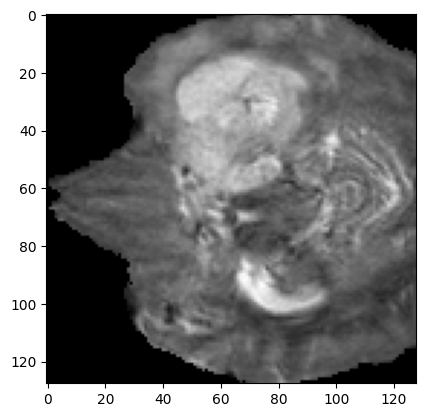

In [20]:
working_dir = "/kaggle/working/dataset/"
x = np.load(working_dir + 't2/img_25.npy')
plt.imshow(x, cmap='gray')

# Dataset

In [21]:
class Dataset(Dataset):
    def __init__(self, datapath=working_dir, augmentation=None):
        self.augmentation = augmentation
        self.folderpaths = {
            'mask': os.path.join(datapath, 'seg/'),
            't1': os.path.join(datapath, 't1/'),
            't1ce': os.path.join(datapath, 't1ce/'),
            't2': os.path.join(datapath, 't2/'),
            'flair': os.path.join(datapath, 'flair/')
        }
    
    def __getitem__(self, idx):
        images = {}
        for name in self.folderpaths:
          images[name] = np.load(os.path.join(self.folderpaths[name], f'img_{idx}.npy'))

        if self.augmentation:
          images = self.augmentation(image=images['flair'],
                                      mask=images['mask'],
                                      t1=images['t1'],
                                      t1ce=images['t1ce'],
                                      t2=images['t2'])
          images['flair'] = images['image']

        for name in images:
          images[name] = torch.from_numpy(images[name])

        # stack modalities
        input = torch.stack([images['t1'],
                             images['t1ce'],
                             images['t2'],
                             images['flair']], dim=0)
        
        # map pixels with value of 4 to 3
        images['mask'][images['mask']==4] = 3

        # one-hot encode truth label
        images['mask'] = F.one_hot(images['mask'].long().unsqueeze(0), num_classes = 4).permute(0,3,1,2).contiguous().squeeze(0)

        return input.float(), images['mask'].long()
    
    def __len__(self):
        return len(os.listdir(self.folderpaths['mask'])) - 1

In [22]:
augmentation = A.Compose([
    A.OneOf([
        A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=0.5)                  
        ], p=0.8),
    A.RandomBrightnessContrast(p=0.8),
    ], 
    additional_targets={'t1':'image',
                          't1ce':'image',
                          't2':'image'})

valid_test_dataset = Dataset(datapath=working_dir,
                             augmentation=None)

train_dataset = Dataset(datapath=working_dir,
                        augmentation=augmentation)

# take 60%/20%/20% of the dataset for train/val/test 
train_length=int(0.6 * len(valid_test_dataset))
valid_length = int(0.2 * len(valid_test_dataset))
test_length = len(valid_test_dataset) - train_length - valid_length

_, valid_dataset, test_dataset = torch.utils.data.random_split(valid_test_dataset, (train_length,valid_length,test_length), generator=torch.Generator().manual_seed(42))

train_dataset, _, _ = torch.utils.data.random_split(train_dataset, (train_length,valid_length,test_length), generator=torch.Generator().manual_seed(42))


train_loader= DataLoader(train_dataset,
                      batch_size=16,
                      num_workers=2,
                      shuffle=True)

valid_loader= DataLoader(valid_dataset,
                      batch_size=1,
                      num_workers=2,
                      shuffle=False)

test_loader= DataLoader(test_dataset,
                      batch_size=1,
                      num_workers=2,
                      shuffle=False)

/tmp/ipykernel_19/2897171150.py:3: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
/tmp/ipykernel_19/2897171150.py:5: UserWarning: Argument(s) 'shift_limit' are not valid for transform OpticalDistortion
  A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=0.5)


In [23]:
a,b=next(iter(train_loader))

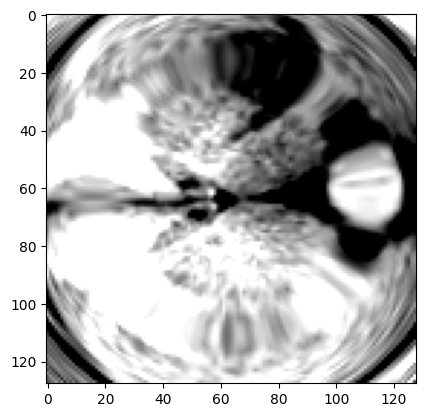

In [24]:
plt.imshow(a[0,0],cmap='gray')

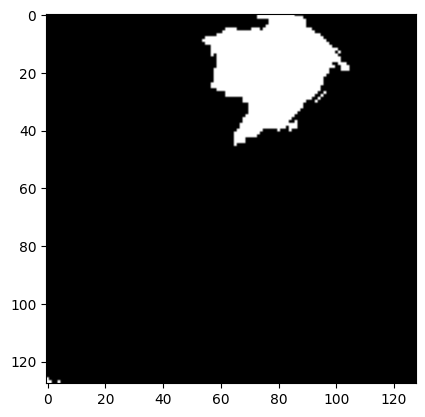

In [25]:
bb = torch.argmax(b,1)
plt.imshow(bb[0],cmap='gray')

# Train Model

In [26]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
!nvidia-smi

Mon Aug  4 10:04:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P0             25W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [27]:
# import model
MODEL = smp.Unet(encoder_name='resnet50',
                 encoder_depth=5,
                 encoder_weights='imagenet',
                 decoder_channels=[1024,512,256,128,64],
                 in_channels=4,
                 classes=4,
                 activation=None)

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [28]:
backgroundchannel = [0]

DICE_LOSS = smp.utils.losses.DiceLoss(activation='softmax2d')  

OPTIMIZER = torch.optim.Adam([ 
    dict(params=MODEL.parameters(), lr=0.0001),
])

METRICS = [
    smp.utils.metrics.IoU(threshold=0.5,
                          ignore_channels=backgroundchannel, 
                          activation='softmax2d'),
    smp.utils.metrics.Fscore(ignore_channels=backgroundchannel, 
                            activation='softmax2d'),
]

In [29]:
os.listdir("./")

['__notebook__.ipynb', 'dataset']

In [30]:
train_epoch = smp.utils.train.TrainEpoch(
    model=MODEL,
    loss=DICE_LOSS,
    metrics=[],
    optimizer=OPTIMIZER,
    device=DEVICE,
    verbose=True
)
valid_epoch = smp.utils.train.ValidEpoch(
    model=MODEL,
    loss=DICE_LOSS,
    metrics=METRICS,
    device=DEVICE,
    verbose=True
)

max_dice_score = 0
stats = {
    'train_loss' : [],
    'valid_loss' : [],
    'fscore' : [],
    'iou_score' : []
}

for i in range(50):
  print(f'\n --- Epoch {i} --- ')
  train_logs = train_epoch.run(train_loader)
  valid_logs = valid_epoch.run(valid_loader)
  
  if max_dice_score < valid_logs['fscore']:
    max_dice_score = valid_logs['fscore']
    torch.save(MODEL.state_dict(), f'./model.pth')
    print('model saved!')
  
  # loss statistics
  stats['train_loss'].append(train_logs['dice_loss'])
  stats['valid_loss'].append(valid_logs['dice_loss'])

  # metric statistics
  stats['fscore'].append(valid_logs['fscore'])
  stats['iou_score'].append(valid_logs['iou_score'])
  np.save(f'./model.npy', stats)
  
  # reduce learning rate
  # if i == 40:
  #       OPTIMIZER.param_groups[0]['lr'] = 1e-5
  #       print('Decrease decoder learning rate to 1e-5!')
  


 --- Epoch 0 --- 
valid: 100%|██████████| 399/399 [00:06<00:00, 60.91it/s, dice_loss - 0.1256, iou_score - 0.2969, fscore - 0.399]
model saved!

 --- Epoch 1 --- 
valid: 100%|██████████| 399/399 [00:06<00:00, 63.38it/s, dice_loss - 0.06051, iou_score - 0.3928, fscore - 0.5006]
model saved!

 --- Epoch 2 --- 
valid: 100%|██████████| 399/399 [00:06<00:00, 63.92it/s, dice_loss - 0.04608, iou_score - 0.4622, fscore - 0.5726]
model saved!

 --- Epoch 3 --- 
valid: 100%|██████████| 399/399 [00:06<00:00, 63.41it/s, dice_loss - 0.03751, iou_score - 0.4825, fscore - 0.5881]
model saved!

 --- Epoch 4 --- 
valid: 100%|██████████| 399/399 [00:06<00:00, 63.95it/s, dice_loss - 0.03451, iou_score - 0.4911, fscore - 0.6011]
model saved!

 --- Epoch 5 --- 
valid: 100%|██████████| 399/399 [00:06<00:00, 63.00it/s, dice_loss - 0.03168, iou_score - 0.4727, fscore - 0.5718]

 --- Epoch 6 --- 
valid: 100%|██████████| 399/399 [00:06<00:00, 63.59it/s, dice_loss - 0.02987, iou_score - 0.5151, fscore - 0.6236]

Text(0.5, 1.0, 'Train and Validation Loss')

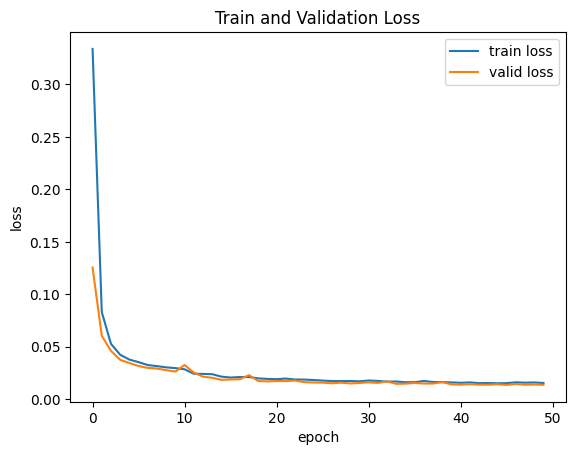

In [31]:
STATS = np.load(f'./model.npy', allow_pickle='TRUE').item()
plt.plot(STATS['train_loss'], label='train loss')
plt.plot(STATS['valid_loss'], label='valid loss')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Train and Validation Loss')

Text(0.5, 1.0, 'Fscore')

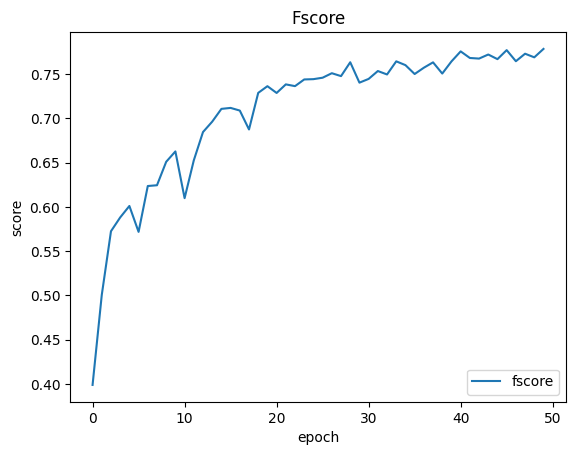

In [32]:
STATS = np.load(f'./model.npy', allow_pickle='TRUE').item()
plt.plot(STATS['fscore'], label='fscore')
plt.legend(loc="lower right")
plt.ylabel('score')
plt.xlabel('epoch')
plt.title('Fscore')

# Test Model

In [33]:
MODEL.load_state_dict(torch.load('./model.pth'))

<All keys matched successfully>

In [34]:
subregions = {
    'all': [0],
    'ncr': [0,2,3],
    'ed': [0,1,3],
    'tc': [0,1,2],
}

for subregion in subregions:
  valid_epoch = smp.utils.train.ValidEpoch(
      model=MODEL,
      loss=DICE_LOSS,
      metrics=[smp.utils.metrics.Fscore(activation='softmax2d', ignore_channels=subregions[subregion])],
      device=DEVICE,
      verbose=False
  )
  valid_log = valid_epoch.run(test_loader)
  print(subregion, valid_log['fscore'])

all 0.765449533417451
ncr 0.7680362833277122
ed 0.7577432876290623
tc 0.8213220706511839


# Single Scan


In [36]:
dirs = ["gifimg", "gifimg/t1", "gifimg/t1ce", "gifimg/t2", "gifimg/flair", "gifimg/seg", "gifimg/pred", "gifimg/label"]

dirs = ["/kaggle/working/" + i for i in dirs]
[os.makedirs(i, exist_ok=True) for i in dirs]

[None, None, None, None, None, None, None, None]

In [37]:
c=0
for i in range(1):
    for name in imgpath:
      imgs[name] = loadimg(imgpath[name][i])
    
    for j in range(155):
        for name in imgs:
          imgslice[name] = imgs[name][:,:,j]
          imgslice[name] = cropcentre(imgslice[name], 128, 128)
        
        if imgslice['flair'].max() == 0:
          continue
        imgslice['flair'] *= 255.0/imgslice['flair'].max()
        Image.fromarray(imgslice['flair']).convert('L').save(f'./gifimg/img_{c}.png')

        for name in ['t1','t2','t1ce','flair']:
          imgslice[name] = normalizeslice(imgslice[name])
        for name in imgslice:
          np.save(f'./gifimg/{name}/img_{c}.npy', imgslice[name])
        c+=1       

In [38]:
gif_dataset = Dataset(datapath='/kaggle/working/gifimg/',
                           augmentation=None)

gif_loader= DataLoader(gif_dataset,
                            batch_size=1,
                            num_workers=2,
                            shuffle=False)

subregions = {
    'all': [0],
    'ncr': [0,2,3],
    'ed': [0,1,3],
    'tc': [0,1,2],
}

for subregion in subregions:
  valid_epoch = smp.utils.train.ValidEpoch(
      model=MODEL,
      loss=DICE_LOSS,
      metrics=[smp.utils.metrics.Fscore(activation='softmax2d', ignore_channels=subregions[subregion])],
      device=DEVICE,
      verbose=False
  )
  valid_log = valid_epoch.run(gif_loader)
  print(subregion, valid_log['fscore'])

all 0.7925622042881463
ncr 0.8397787753914773
ed 0.8309185316829408
tc 0.7630790495799491


# Coronal/Sagittal View


In [40]:
dirs = ["coronal", "coronal/t1", "coronal/t1ce", "coronal/t2", "coronal/flair", "coronal/seg", "coronal/pred", "coronal/label"]
dirs += ["sagittal", "sagittal/t1", "sagittal/t1ce", "sagittal/t2", "sagittal/flair", "sagittal/seg", "sagittal/pred", "sagittal/label"]

dirs = ["/kaggle/working/" + i for i in dirs]
[os.makedirs(i, exist_ok=True) for i in dirs]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [41]:
os.listdir("./")

['coronal',
 'model.pth',
 '__notebook__.ipynb',
 'model.npy',
 'sagittal',
 'gifimg',
 'dataset']

In [42]:
# save a single patient scan of each coronal and sagittal view
c=0
for i in range(1):
    for name in imgpath:
      imgs[name] = loadimg(imgpath[name][i])
    
    for j in range(155):
        for name in imgs:
          imgslice[name] = imgs[name][:,j,:]
          imgslice[name] = cropcentre(imgslice[name], 128, 128)
        
        if imgslice['flair'].max() == 0:
          continue
        imgslice['flair'] *= 255.0/imgslice['flair'].max()
        Image.fromarray(imgslice['flair']).convert('L').save(f'./coronal/img_{c}.png')
        
        for name in ['t1','t2','t1ce','flair']:
          imgslice[name] = normalizeslice(imgslice[name])
        for name in imgslice:
          np.save(f'./coronal/{name}/img_{c}.npy', imgslice[name])
        c+=1
    c=0
    for j in range(155):
        for name in imgs:
          imgslice[name] = imgs[name][j,:,:]
          imgslice[name] = cropcentre(imgslice[name], 128, 128)
        
        if imgslice['flair'].max() == 0:
          continue
        imgslice['flair'] *= 255.0/imgslice['flair'].max()
        Image.fromarray(imgslice['flair']).convert('L').save(f'./sagittal/img_{c}.png')
        
        for name in ['t1','t2','t1ce','flair']:
          imgslice[name] = normalizeslice(imgslice[name])
        for name in imgslice:
          np.save(f'./sagittal/{name}/img_{c}.npy', imgslice[name])
        c+=1

In [43]:
coronal_dataset = Dataset(datapath='./coronal/',
                           augmentation=None)

coronal_loader= DataLoader(coronal_dataset,
                            batch_size=1,
                            num_workers=2,
                            shuffle=False)

sagittal_dataset = Dataset(datapath='./sagittal/',
                           augmentation=None)

sagittal_loader= DataLoader(sagittal_dataset,
                            batch_size=1,
                            num_workers=2,
                            shuffle=False)

In [44]:
subregions = {
    'all': [0],
    'ncr': [0,2,3],
    'ed': [0,1,3],
    'tc': [0,1,2],
}

print('--- Coronal ---')
for subregion in subregions:
  valid_epoch = smp.utils.train.ValidEpoch(
      model=MODEL,
      loss=DICE_LOSS,
      metrics=[smp.utils.metrics.Fscore(activation='softmax2d', ignore_channels=subregions[subregion])],
      device=DEVICE,
      verbose=False
  )
  valid_log = valid_epoch.run(coronal_loader)
  print(subregion, valid_log['fscore'])

print('--- Sagittal ---')
for subregion in subregions:
  valid_epoch = smp.utils.train.ValidEpoch(
      model=MODEL,
      loss=DICE_LOSS,
      metrics=[smp.utils.metrics.Fscore(activation='softmax2d', ignore_channels=subregions[subregion])],
      device=DEVICE,
      verbose=False
  )
  valid_log = valid_epoch.run(sagittal_loader)
  print(subregion, valid_log['fscore'])

--- Coronal ---
all 0.7886525527111639
ncr 0.7611286628417507
ed 0.805078922369795
tc 0.6952924744790627
--- Sagittal ---
all 0.46732955348506156
ncr 0.8003750433075797
ed 0.4665852833147173
tc 0.744775562038399


# Load model/statistics

In [45]:
MODEL = smp.Unet(encoder_name='resnet50',
                 encoder_depth=5,
                 encoder_weights='imagenet',
                 decoder_channels=[1024,512,256,128,64],
                 in_channels=4,
                 classes=4,
                 activation=None)

MODEL.load_state_dict(torch.load(f'./model.pth'))
STATS = np.load(f'./model.npy', allow_pickle='TRUE').item()